Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
#root_path = 'gdrive/My Drive/CNN_Skin_Cancer_ISIC/'

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("gdrive/My Drive/CNN_Skin_Cancer_ISIC/Train/")
data_dir_test = pathlib.Path("gdrive/My Drive/CNN_Skin_Cancer_ISIC/Test/")

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, 
                                                               seed = 123, 
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size, 
                                                               validation_split=0.2, 
                                                               subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, 
                                                             seed = 123, 
                                                             image_size=(img_height, img_width), 
                                                             batch_size=batch_size, 
                                                             validation_split=0.2, 
                                                             subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

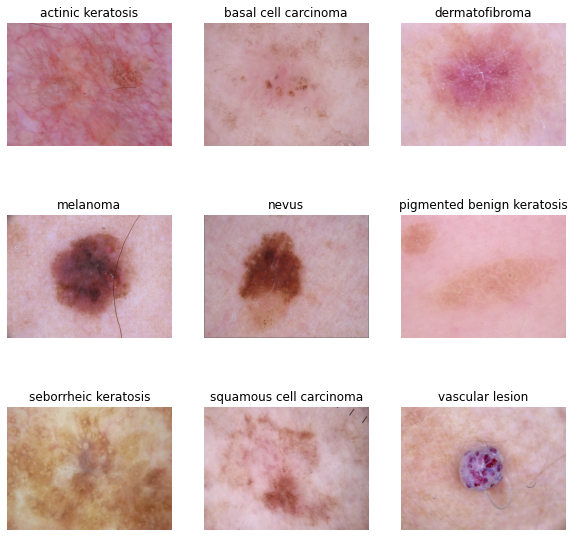

In [ ]:
### your code goes here, you can use training or validation data to visualize
import glob

plt.figure(figsize=(10, 10))

for i, class_ in enumerate(list(class_names)):
    plt.subplot(3, 3, i+1)
    data_path = os.path.join(str(data_dir_train), class_)
    file_path = glob.glob(os.path.join(data_path,'*.jpg'))[0]
    img = PIL.Image.open(file_path)
    plt.imshow(img)
    plt.title(class_)
    plt.axis("off")
plt.show()

In [ ]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)



```
# This is formatted as code
```

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
### Your code goes here
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l2

num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size. 
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size. 
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size. 
  layers.MaxPooling2D(),
  #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
  layers.Flatten(),
  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  layers.Dense(128, activation='relu'),
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
  layers.Dense(num_classes)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
])


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:
### Todo, choose an appropirate optimiser and loss function
#RMSprop. RMSprop is a very effective, but currently unpublished adaptive learning rate method
#Adam. Adam is a recently proposed update that looks a bit like RMSProp with momentum. The (simplified) update looks as follows:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [ ]:
#train the model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 334s 2s/step - loss: 1.9553 - accuracy: 0.2645 - val_loss: 1.8075 - val_accuracy: 0.3758
Epoch 2/20
56/56 [==============================] - 55s 983ms/step - loss: 1.6902 - accuracy: 0.3912 - val_loss: 1.5313 - val_accuracy: 0.4698
Epoch 3/20
56/56 [==============================] - 56s 995ms/step - loss: 1.5070 - accuracy: 0.4671 - val_loss: 1.4662 - val_accuracy: 0.5056
Epoch 4/20
56/56 [==============================] - 55s 984ms/step - loss: 1.4012 - accuracy: 0.5050 - val_loss: 1.3411 - val_accuracy: 0.5391
Epoch 5/20
56/56 [==============================] - 55s 977ms/step - loss: 1.3669 - accuracy: 0.5223 - val_loss: 1.4254 - val_accuracy: 0.5548
Epoch 6/20
56/56 [==============================] - 55s 975ms/step - loss: 1.2027 - accuracy: 0.5765 - val_loss: 1.4448 - val_accuracy: 0.5056
Epoch 7/20
56/56 [==============================] - 55s 986ms/step - loss: 1.1100 - accuracy: 0.6161 - val_loss: 1.4487 - val_accuracy: 0.5257
E

### Visualizing training results

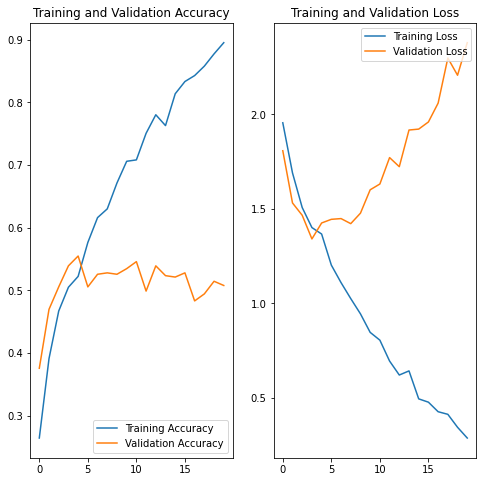

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings after the model fit:

1.   There is an evidence of model is overfitting 
2.   Validation accuracy is very low even when we had a very high training accuracy
3. Validation loss also increases with more passes.



### Data Augmentation 

In [ ]:
#  data augumentation strategy. 
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

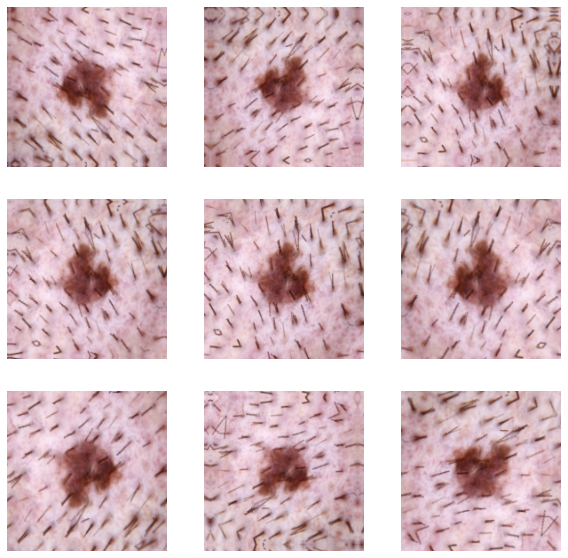

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
num_classes=9
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])




### Compiling the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 65s 1s/step - loss: 1.9304 - accuracy: 0.2701 - val_loss: 1.7238 - val_accuracy: 0.4116
Epoch 2/20
56/56 [==============================] - 64s 1s/step - loss: 1.6819 - accuracy: 0.4040 - val_loss: 1.5798 - val_accuracy: 0.4698
Epoch 3/20
56/56 [==============================] - 64s 1s/step - loss: 1.5419 - accuracy: 0.4464 - val_loss: 1.4877 - val_accuracy: 0.4810
Epoch 4/20
56/56 [==============================] - 64s 1s/step - loss: 1.4436 - accuracy: 0.4888 - val_loss: 1.4334 - val_accuracy: 0.4966
Epoch 5/20
56/56 [==============================] - 64s 1s/step - loss: 1.3430 - accuracy: 0.5285 - val_loss: 1.3733 - val_accuracy: 0.5235
Epoch 6/20
56/56 [==============================] - 64s 1s/step - loss: 1.3108 - accuracy: 0.5469 - val_loss: 1.4402 - val_accuracy: 0.4877
Epoch 7/20
56/56 [==============================] - 64s 1s/step - loss: 1.2992 - accuracy: 0.5374 - val_loss: 1.3386 - val_accuracy: 0.5347
Epoch 8/20
56/56 [==

### Visualizing the results

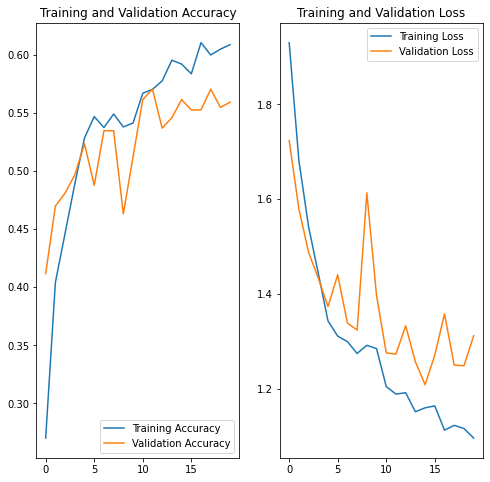

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings

1.   Overfitting is reduced. not much of difference is there in the training accuracy and validation accuracy now.
2. there is a lot of improvement in the overfitting now as compared to the previous model 
3. Overall accuracy of the traning set is reduced a lot with the aurgmentation 


#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
class_size = {}

for name in class_names:
    class_size[name] = len(list(data_dir_train.glob(name+'/*.jpg')))

class_size

{'actinic keratosis': 114,
 'basal cell carcinoma': 376,
 'dermatofibroma': 95,
 'melanoma': 438,
 'nevus': 357,
 'pigmented benign keratosis': 462,
 'seborrheic keratosis': 77,
 'squamous cell carcinoma': 181,
 'vascular lesion': 139}

Findings :  We can clearly see that the class imbalance exists, every class has different number of samples in it.
#### - "seborrheic keratosis" class has the least number of samples.
#### - "pigmented benign keratosis" and "melanoma" classes dominate the data in terms proportionate number of samples.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
path_to_training_dataset = "gdrive/My Drive/CNN_Skin_Cancer_ISIC/Train/"

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.


Initialised with 114 image(s) found.
Output directory set to gdrive/My Drive/CNN_Skin_Cancer_ISIC/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1907903FD0>: 100%|██████████| 500/500 [00:23<00:00, 21.67 Samples/s]


Initialised with 376 image(s) found.
Output directory set to gdrive/My Drive/CNN_Skin_Cancer_ISIC/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1907828F10>: 100%|██████████| 500/500 [00:22<00:00, 21.81 Samples/s]


Initialised with 95 image(s) found.
Output directory set to gdrive/My Drive/CNN_Skin_Cancer_ISIC/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1907947310>: 100%|██████████| 500/500 [00:24<00:00, 20.62 Samples/s]


Initialised with 438 image(s) found.
Output directory set to gdrive/My Drive/CNN_Skin_Cancer_ISIC/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F19078C1AD0>: 100%|██████████| 500/500 [01:57<00:00,  4.26 Samples/s]


Initialised with 357 image(s) found.
Output directory set to gdrive/My Drive/CNN_Skin_Cancer_ISIC/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1907BBA890>: 100%|██████████| 500/500 [01:24<00:00,  5.94 Samples/s]


Initialised with 462 image(s) found.
Output directory set to gdrive/My Drive/CNN_Skin_Cancer_ISIC/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1907902B90>: 100%|██████████| 500/500 [00:22<00:00, 22.16 Samples/s]


Initialised with 77 image(s) found.
Output directory set to gdrive/My Drive/CNN_Skin_Cancer_ISIC/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F190784DFD0>: 100%|██████████| 500/500 [00:50<00:00,  9.84 Samples/s]


Initialised with 181 image(s) found.
Output directory set to gdrive/My Drive/CNN_Skin_Cancer_ISIC/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1907955C10>: 100%|██████████| 500/500 [00:22<00:00, 22.56 Samples/s]


Initialised with 139 image(s) found.
Output directory set to gdrive/My Drive/CNN_Skin_Cancer_ISIC/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1907902990>: 100%|██████████| 500/500 [00:22<00:00, 21.82 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4668


### Lets see the distribution of augmented data after adding new images to the original training data.

In [32]:
class_size = {}

for name in class_names:
    class_size[name] = len(list(data_dir_train.glob(name+'/output/*.jpg')))

class_size

{'actinic keratosis': 668,
 'basal cell carcinoma': 500,
 'dermatofibroma': 500,
 'melanoma': 500,
 'nevus': 500,
 'pigmented benign keratosis': 500,
 'seborrheic keratosis': 500,
 'squamous cell carcinoma': 500,
 'vascular lesion': 500}

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.


Note:'actinic keratosis': 668 has bit more and i stopped the first instance. so few images are duplciated in this. Due to large processing time dont want to delete and rerun


#### **Todo**: Train the model on the data created using Augmentor

In [33]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [34]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6907 files belonging to 9 classes.
Using 5526 files for training.


#### **Todo:** Create a validation dataset

In [35]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6907 files belonging to 9 classes.
Using 1381 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [36]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [37]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [38]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
173/173 [==============================] - 206s 1s/step - loss: 1.7857 - accuracy: 0.3111 - val_loss: 1.5374 - val_accuracy: 0.4041
Epoch 2/30
173/173 [==============================] - 172s 995ms/step - loss: 1.4309 - accuracy: 0.4607 - val_loss: 1.3004 - val_accuracy: 0.5047
Epoch 3/30
173/173 [==============================] - 169s 975ms/step - loss: 1.2017 - accuracy: 0.5637 - val_loss: 1.1657 - val_accuracy: 0.5800
Epoch 4/30
173/173 [==============================] - 168s 974ms/step - loss: 1.0160 - accuracy: 0.6341 - val_loss: 1.2071 - val_accuracy: 0.5720
Epoch 5/30
173/173 [==============================] - 169s 976ms/step - loss: 0.8587 - accuracy: 0.6922 - val_loss: 0.9729 - val_accuracy: 0.6531
Epoch 6/30
173/173 [==============================] - 169s 976ms/step - loss: 0.6735 - accuracy: 0.7515 - val_loss: 0.9030 - val_accuracy: 0.6937
Epoch 7/30
173/173 [==============================] - 169s 979ms/step - loss: 0.5738 - accuracy: 0.8008 - val_loss: 0.8516 - va

#### **Todo:**  Visualize the model results

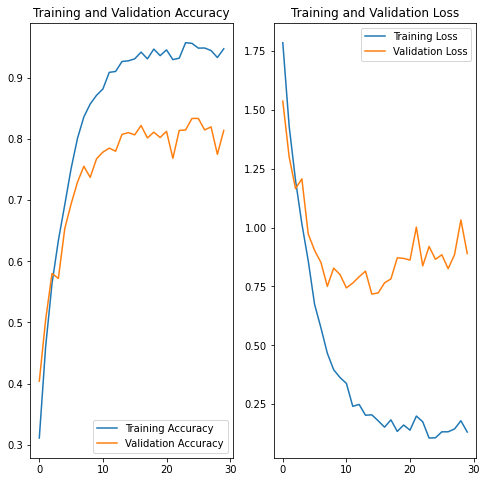

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



1.   We have good model now with more than 90% accuracy on testing data and more 80% accuracy on the validation data
2.   Overfitting problem is reduced by a large margin, difference between the train and test data is reduced now. this can further be reduced by adding more experients on the CNN layers, adding more images and using iterations and experiments with Augmentor.
3. Overall reblancing helped a lot w.r.t to increase accuracy and reducing overfitting. 
4. We can continue more experiments to reduce overfitting, as there is still scope, validation data accurracy can still be closer to trainig data.  
5. No of epochs can also be increased with further experiements to get better results with the said improvements. 


